<a href="https://colab.research.google.com/github/IMTIYAZ2104/My-Projects/blob/main/Multi_Armed_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h2>Multi-Armed Bandit Homework Template Jupyter Notebook</h2>
  <h2>Adapted by Andy (Wen-Chung) Cheng for the Reinforcement Learning course at Florida Atlantic University</h2>
</div>

In [11]:
#Uncomment and run this line if ray is not installed
!pip install ray

In [12]:
import sys
import numpy as np
import ray
import time
import copy

import matplotlib.pyplot as plt
from collections import deque

Set the seed for random generator

In [13]:
np.random.seed(501)

# Define the Bandit Problem

Below is the reward distribution for each arm [3]:

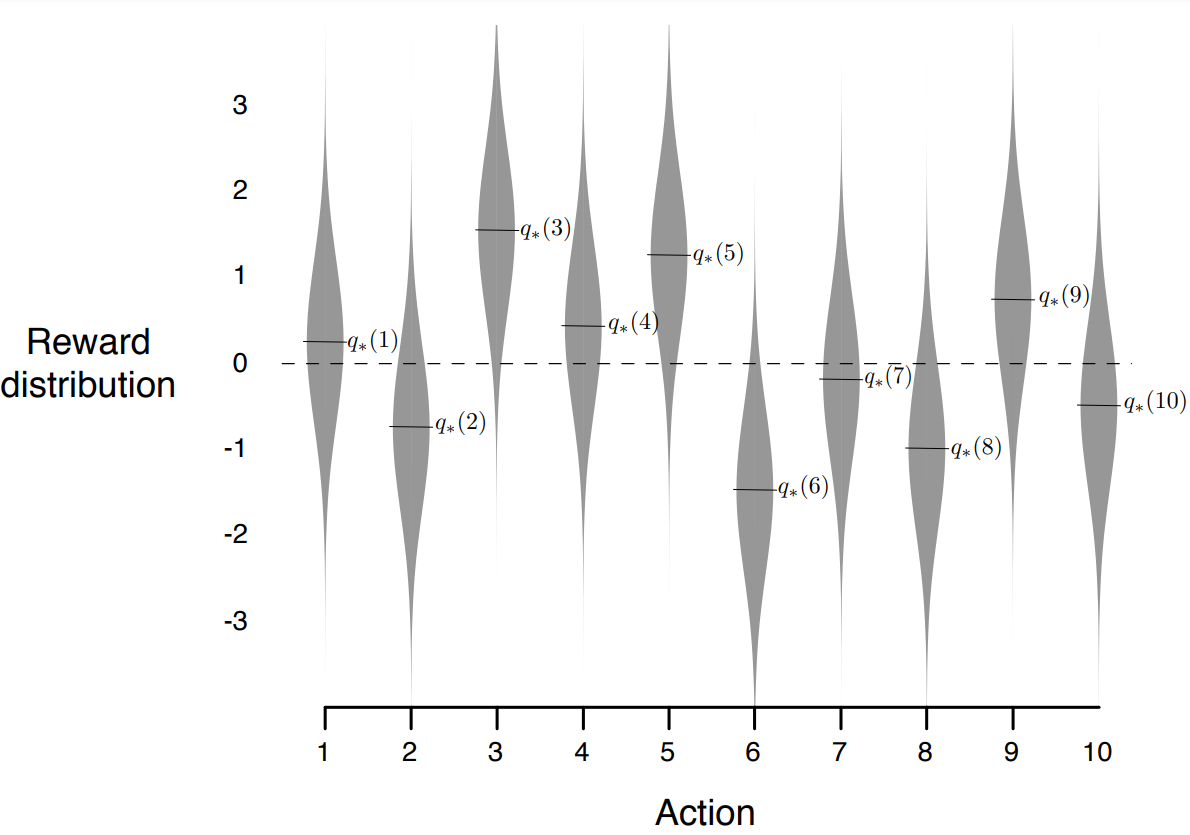

In [14]:
class BanditProblem():
  def __init__(self, arms, stationary=True):
    self.stationary = stationary
    self.bandit_arms_values = np.random.normal(loc=0.0, scale=1.0, size=arms) # get random mean values for each arm
    self.optimal_action_index = np.argmax(self.bandit_arms_values)

  def draw_from_arm(self, arm_index):
    chose_optimal = 1 if arm_index == self.optimal_action_index else 0
    reward = np.random.normal(loc=self.bandit_arms_values[arm_index], scale=1.0) # draw from distribution of each arm

    return reward, chose_optimal

  def step_arm_values(self):
    '''
    Step to be called manually in episode loop.
    '''
    q_star_value_shift = np.random.normal(loc=0.0, scale=0.01, size=len(self.bandit_arms_values))
    self.bandit_arms_values += q_star_value_shift
    self.optimal_action_index = np.argmax(self.bandit_arms_values)

  def reset(self):
    '''Reuse the same bandit problem object as a clean slate, instead of creating a new object'''
    self.bandit_arms_values = np.zeros(shape=len(self.bandit_arms_values))
    self.optimal_action_index = 0

# Incremental Update $ϵ$-greedy agent

We initialise an $\epsilon$-first agent. The update type is an incremental sample average approach:

$Q_{n+1} = Q_{n} + \frac{1}{n}[R_n - Q_n]$

This approach has the downside that all $Q$-value updates are weighted equally, which means that the rewards from the first steps are considered equal to the most recent rewards obtained during the episode. This is a problem when the true action values $Q^*$ are non-stationary (they change during the course of the episode). It means that using the above incremental average solution will take longer and longer to adapt to fluctations in $Q^*$ the longer the episode goes on. This is because the more recent updates have less of an impact on the update the longer the episode goes on for. The $\epsilon$-first bandit also uses this update rule. Slight improvement can be done if the Q values are initialized to non-zero values, which can be seen later on. The pseudo code of such agent is shown below:

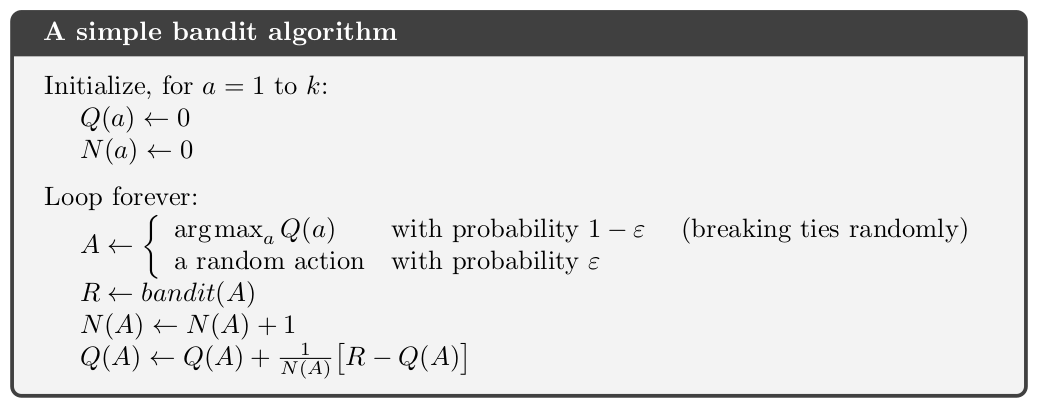

We demonstrate this empirically below:


In [15]:
class EpsilonGreedyAgent():
  def __init__(self, epsilon, bandit_problem, alpha=0.1, update_type="incremental"):
    self.epsilon = epsilon
    self.alpha = alpha
    self.problem = bandit_problem
    self.update_type = update_type

    self.arm_qs = np.zeros(len(bandit_problem.bandit_arms_values))
    self.arm_ns = np.zeros(len(bandit_problem.bandit_arms_values))


  def choose_action(self):
    if np.random.rand() > self.epsilon:
      # greedily pull best arm
      choice = np.argmax(self.arm_qs)
    else:
      # explore pull any random arm (still a chance to pull best arm too)
      choice = np.random.randint(0, len(self.arm_qs))

    self.arm_ns[choice] += 1

    reward, optimal = self.problem.draw_from_arm(choice)

    if self.update_type == "incremental":
      self.update_estimate_incremental(choice, reward)
    elif self.update_type == "weighted":
      print('No such update type! Proceeding to use incremental update')
      self.update_estimate_incremental(choice, reward)

    return reward, optimal

  def update_estimate_incremental(self, choice_index, reward):
    self.arm_qs[choice_index] = self.arm_qs[choice_index] + (1/self.arm_ns[choice_index])*(reward - self.arm_qs[choice_index])

# Create parallelisable episode function using Ray
####(to speed things up a bit)

In [16]:
@ray.remote
def run_bandit_episode(steps=10000, stationary=False):
  problem = BanditProblem(arms=10, stationary=stationary)
  agents = []
  # Epsilon values to compare
  epsilons = [0.4, 0.1, 0.01]
  for epsilon in epsilons:
    incremental_update_agent = EpsilonGreedyAgent(epsilon=epsilon, bandit_problem=problem, update_type="incremental")
    agents.append(incremental_update_agent)

  # two rows for each agent: score and optimal_choice
  results = np.zeros((2*len(agents), steps))

  for step in range(steps):
    for i_agent, agent in enumerate(agents):
      reward, optimal = agent.choose_action()
      results[i_agent*2, step] = reward
      results[(i_agent*2)+1, step] = optimal
    if not stationary:
      problem.step_arm_values()
  return results


In [17]:
def plot_rewards_and_optimals(results, num_agents, agent_names=[], title=""):

  num_agents = len(agent_names)
  aggregates_score = []
  aggregates_optim = []

  for i_agent in range(0, num_agents):
    agent_rewards_index = i_agent*2
    agent_optims_index = (i_agent*2)+1

    agent_agg_score = np.mean(results[:, agent_rewards_index, :], axis=0)
    agent_agg_choice = np.mean(results[:, agent_optims_index, :], axis=0)

    aggregates_score.append(agent_agg_score)
    aggregates_optim.append(agent_agg_choice)

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(15)

  ax1.set_title("Bandit Avg. Score")
  for i in range(0, num_agents):
    ax1.plot(aggregates_score[i], label=agent_names[i])

  ax2.set_title("Avg. optimal choice selected %")
  for i in range(0, num_agents):
    ax2.plot(aggregates_optim[i], label=agent_names[i])

  fig.suptitle(title)
  plt.legend()
  plt.show()

# 1. Run with a stationary problem

In [34]:
runs = 2000 # run 2000 times and average over these runs, set this lower for increased speed (two hundred should be enough)
steps = 15000 # run each episode for 5000 steps, lower this for increased speed (5000 should be enough)

futures = [run_bandit_episode.remote(steps=steps, stationary=True) for i in range(0, runs)]

tic = time.perf_counter()
stationary_results = ray.get(futures)
toc = time.perf_counter()

print(f"Whole experiment took: {toc - tic} seconds")

print(len(stationary_results))

stationary_results = np.array(stationary_results)

Whole experiment took: 809.3666899220001 seconds
2000


In [35]:
stationary_results.shape

(2000, 6, 15000)

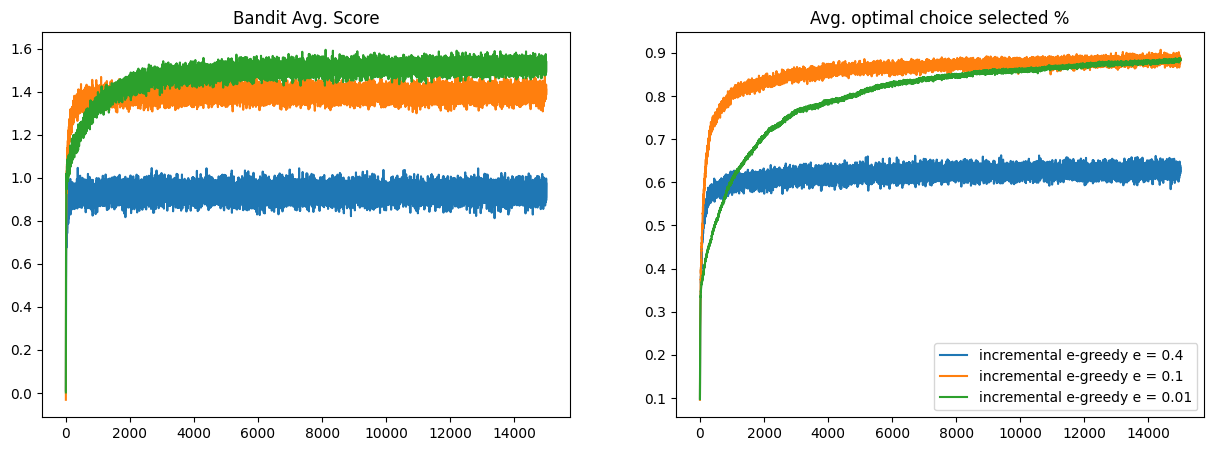

In [36]:
plot_rewards_and_optimals(results=stationary_results, num_agents=3, agent_names=["incremental e-greedy e = 0.4", "incremental e-greedy e = 0.1", "incremental e-greedy e = 0.01"])

# References

1.   https://www.daniel-scott-carter.com/%f0%9f%a4%96-ai/
2.   https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb
3.   Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.




